# Model-1: Adaptive Drift Detection based Refit Auto-ML Model

### Cell 1: Data Loading and Inspection

In [1]:
# Cell 1: Data Loading and Inspection

import pandas as pd
import numpy as np

# Load dataset
file_path = 'combined_late.csv'  # Ensure the dataset is placed in the same directory
data = pd.read_csv(file_path)

# Inspect dataset structure
print("Dataset Summary:")
print(data.info())

print("\nDataset Head:")
print(data.head())

# Check unique countries
if 'country' in data.columns:
    print("\nUnique Countries in Dataset:")
    print(data['country'].unique())
else:
    print("\nNo 'country' column found in the dataset!")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Check dataset range if 'date' column exists
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    print("\nDate Range in Dataset:")
    print(data['date'].min(), "to", data['date'].max())

# Save a summary report
data.describe(include='all').to_csv('dataset_summary.csv')
print("\nDataset summary saved to 'dataset_summary.csv'")


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3432 entries, 0 to 3431
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                3432 non-null   object 
 1   country                                             3432 non-null   object 
 2   cases                                               3432 non-null   int64  
 3   deaths                                              3432 non-null   int64  
 4   popData2020                                         3432 non-null   int64  
 5   continentExp                                        3432 non-null   object 
 6   retail_and_recreation_percent_change_from_baseline  3432 non-null   float64
 7   grocery_and_pharmacy_percent_change_from_baseline   3432 non-null   float64
 8   parks_percent_change_from_baseline                  3432 non-

/data/s4022297/env/uc/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


### Cell 2: Data Preprocessing


In [2]:
# Cell 2: Data Preprocessing

from sklearn.preprocessing import StandardScaler
import pandas as pd

# Drop unnecessary columns (e.g., date if not required for modeling)
columns_to_drop = ['date']  # Adjust based on the dataset structure
if 'date' in data.columns:
    data = data.drop(columns=columns_to_drop, errors='ignore')

# Handle categorical columns with one-hot encoding (e.g., country)
data_encoded = pd.get_dummies(data, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)
data_scaled = pd.DataFrame(data_scaled, columns=data_encoded.columns)

# Save preprocessed data for reuse
preprocessed_path = "preprocessed_data.csv"
data_scaled.to_csv(preprocessed_path, index=False)
print(f"Preprocessed data saved to '{preprocessed_path}'")

# Option for selecting one country for testing
country_option = input("Enter a country name to test (or leave blank to proceed with all countries): ")
if country_option:
    if 'country_' + country_option in data_encoded.columns:
        print(f"Filtering data for country: {country_option}")
        data_scaled = data_encoded[data_encoded['country_' + country_option] == 1]
    else:
        print(f"Country '{country_option}' not found. Proceeding with all countries.")

# Summary
print("Data Preprocessing Complete:")
print(f"Shape of Preprocessed Data: {data_scaled.shape}")
print(f"Columns: {list(data_scaled.columns)}")


Preprocessed data saved to 'preprocessed_data.csv'
Filtering data for country: Italy
Data Preprocessing Complete:
Shape of Preprocessed Data: (132, 36)
Columns: ['cases', 'deaths', 'popData2020', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'walking', 'driving', 'country_Belgium', 'country_Bulgaria', 'country_Croatia', 'country_Czechia', 'country_Denmark', 'country_Estonia', 'country_Finland', 'country_France', 'country_Germany', 'country_Greece', 'country_Hungary', 'country_Ireland', 'country_Italy', 'country_Latvia', 'country_Lithuania', 'country_Luxembourg', 'country_Netherlands', 'country_Norway', 'country_Poland', 'country_Portugal', 'country_Romania', 'country_Slovakia', 'country_Slovenia', 'country_Spain', 'country_Sweden']


### Cell 3: Sliding Window Creation for Time-Series Data

In [3]:
# Cell 3: Sliding Window Creation for Time-Series Data

def create_sliding_windows(data, target_column, window_size, horizon):
    X, y = [], []
    for i in range(len(data) - window_size - horizon):
        X.append(data.iloc[i:i + window_size].drop(columns=[target_column]).values)
        y.append(data.iloc[i + window_size:i + window_size + horizon][target_column].values)
    return np.array(X), np.array(y)

# Parameters for sliding windows
window_size = 14  # Number of past days to use as features
horizon = 7        # Number of future days to predict
target_column = 'deaths'  # Replace with your actual target column name

# Ensure target column exists
if target_column not in data_scaled.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset. Available columns: {data_scaled.columns}")

# Create sliding windows
X, y = create_sliding_windows(data_scaled, target_column, window_size, horizon)

# Split into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Save shapes and verify
print("Sliding Window Dataset Shapes:")
print(f"Training Data: X={X_train.shape}, y={y_train.shape}")
print(f"Validation Data: X={X_val.shape}, y={y_val.shape}")
print(f"Test Data: X={X_test.shape}, y={y_test.shape}")

# Save processed sliding windows for reuse
import joblib
joblib.dump((X_train, y_train, X_val, y_val, X_test, y_test),country_option +'' + 'sliding_window_data.pkl')
print("Sliding window data saved to 'countrysliding_window_data.pkl'")


Sliding Window Dataset Shapes:
Training Data: X=(77, 14, 35), y=(77, 7)
Validation Data: X=(17, 14, 35), y=(17, 7)
Test Data: X=(17, 14, 35), y=(17, 7)
Sliding window data saved to 'countrysliding_window_data.pkl'


### UPDATED Cell 4: Drift Detection and Grouping


In [9]:
import pandas as pd
import numpy as np
from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM

# Initialize drift detectors
adwin = ADWIN()
ddm = DDM()

# Initialize results storage for drift detection
drift_results = []

# Drift severity thresholds
mild_threshold = 0.01
moderate_threshold = 0.03
severe_threshold = 0.05

# Function to detect drift for a single feature using ADWIN
def detect_drift_adwin(reference_data, new_data):
    adwin.reset()
    drift_scores = []
    for val in np.concatenate([reference_data, new_data]):
        adwin.add_element(val)
        drift_scores.append(adwin.detected_change())
    return np.mean(drift_scores)

# Group countries by drift severity
country_groups = {"Mild": [], "Moderate": [], "Significant": []}

# Detect and group countries/features by drift
for feature_idx in range(X_val.shape[2]):  # Iterate over features
    ref_data = X_val[:, :, feature_idx].flatten()
    new_data = X_test[:, :, feature_idx].flatten()

    drift_score = detect_drift_adwin(ref_data, new_data)

    # Save drift data for visualization
    drift_results.append({"Feature": f"Feature_{feature_idx}", "Year": 2021, "Value": np.mean(new_data)})
    drift_results.append({"Feature": f"Feature_{feature_idx}", "Year": 2019, "Value": np.mean(ref_data)})

    # Classify drift severity
    if drift_score < mild_threshold:
        country_groups["Mild"].append(f"Feature_{feature_idx}")
    elif drift_score < moderate_threshold:
        country_groups["Moderate"].append(f"Feature_{feature_idx}")
    else:
        country_groups["Significant"].append(f"Feature_{feature_idx}")

# Save drift results
drift_results_df = pd.DataFrame(drift_results)
drift_results_df.to_csv("drifting_features.csv", index=False)
print("Drifting features saved to 'drifting_features.csv'.")

# Display grouped drift results
print("Drift Groups:")
for severity, features in country_groups.items():
    print(f"{severity} Drift: {len(features)} features")
    print(features)


Drifting features saved to 'drifting_features.csv'.
Drift Groups:
Mild Drift: 29 features
['Feature_1', 'Feature_3', 'Feature_4', 'Feature_6', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34']
Moderate Drift: 6 features
['Feature_0', 'Feature_2', 'Feature_5', 'Feature_7', 'Feature_8', 'Feature_9']
Significant Drift: 0 features
[]


### UPDATED Cell-5: Adaptive Drift Detection & Model-Refit Mechanism


In [10]:
from autosklearn.regression import AutoSklearnRegressor
from tqdm import tqdm
import os
import joblib
import autosklearn
import time  # Added for tracking training time

# Add a small random noise to force continuous interpretation
y_train = y_train.astype(np.float64) + np.random.uniform(low=1e-6, high=1e-5, size=y_train.shape)
y_val = y_val.astype(np.float64) + np.random.uniform(low=1e-6, high=1e-5, size=y_val.shape)
y_test = y_test.astype(np.float64) + np.random.uniform(low=1e-6, high=1e-5, size=y_test.shape)

# Adaptive strategy: Define actions based on drift severity
def adaptive_training(X_train, y_train, X_val, y_val, severity):
    try:
        if severity == "Mild":
            print("Mild drift detected: No action taken.")
            return None  # No retraining required
        elif severity == "Moderate":
            print("Moderate drift detected: Partial refit in progress...")
            try:
                # Flatten input features for partial refit
                X_train_flat = X_train.reshape(X_train.shape[0], -1)
                y_train_multioutput = y_train.astype(np.float64)  # Ensure target is continuous

                # Path to baseline model
                baseline_model_path = "baseline_automl_model.joblib"

                # Train baseline model if not found
                if not os.path.exists(baseline_model_path):
                    print("Baseline model not found. Training baseline AutoML model...")
                    baseline_automl = AutoSklearnRegressor(
                        time_left_for_this_task=1800,
                        per_run_time_limit=300,
                        n_jobs=-1,
                        metric=autosklearn.metrics.mean_squared_error,
                        resampling_strategy="cv",
                        resampling_strategy_arguments={"folds": 5},
                    )
                    baseline_automl.fit(X_train_flat, y_train_multioutput)
                    joblib.dump(baseline_automl, baseline_model_path)
                    print(f"Baseline model trained and saved to {baseline_model_path}.")
                else:
                    print(f"Loading existing baseline model from {baseline_model_path}.")
                    baseline_automl = joblib.load(baseline_model_path)

                # Perform partial refit
                baseline_automl.refit(X_train_flat, y_train_multioutput)
                print(f"Partial refit completed for Moderate Drift feature.")
                return baseline_automl

            except Exception as e:
                print(f"Error during partial refit: {e}")
                return None

        elif severity == "Significant":
            print("Significant drift detected: Full retrain in progress...")
            try:
                # Flatten input features for training
                X_train_flat = X_train.reshape(X_train.shape[0], -1)
                y_train_multioutput = y_train  # Shape: (n_samples, horizon)

                automl_model = AutoSklearnRegressor(
                    time_left_for_this_task=3600,
                    per_run_time_limit=300,
                    n_jobs=-1,
                    metric=autosklearn.metrics.mean_squared_error,
                    resampling_strategy="cv",
                    resampling_strategy_arguments={"folds": 5},
                )
                automl_model.fit(X_train_flat, y_train_multioutput)
                return automl_model
            except Exception as e:
                print(f"Error during full retrain: {e}")
                return None

    except Exception as e:
        print(f"Error during adaptive training for {severity} drift: {e}")
        return None


# Progress tracking and model training
progress_bar = tqdm(total=len(country_groups["Mild"] + country_groups["Moderate"] + country_groups["Significant"]),
                    desc="Training Progress")

trained_models = {}
training_times = []  # To store training times for each feature

for severity, features in country_groups.items():
    for feature_idx in features:
        print(f"Processing feature {feature_idx} ({severity} drift)...")
        start_time = time.time()  # Start timing

        # Train model
        model = adaptive_training(X_train, y_train, X_val, y_val, severity)

        end_time = time.time()  # End timing
        training_duration = (end_time - start_time) / 60  # Convert seconds to minutes

        # Log training time
        training_times.append({
            "Feature": f"Feature_{feature_idx}",
            "Drift Severity": severity,
            "Training Time (mins)": training_duration,
        })

        if model:
            trained_models[f"Feature_{feature_idx}_{severity}"] = model
        else:
            print(f"No model trained for Feature_{feature_idx}.")
        progress_bar.update(1)

progress_bar.close()

# Save all trained models
joblib.dump(trained_models, "adaptive_trained_models.pkl")
print("All trained models saved to 'adaptive_trained_models.pkl'.")

# Save training times to CSV
training_times_df = pd.DataFrame(training_times)
training_times_df.to_csv("adaptive_training_times.csv", index=False)
print("Training times saved to 'adaptive_training_times.csv'.")

Training Progress:   0%|          | 0/35 [00:00<?, ?it/s]

Processing feature Feature_1 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_1.
Processing feature Feature_3 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_3.
Processing feature Feature_4 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_4.
Processing feature Feature_6 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_6.
Processing feature Feature_10 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_10.
Processing feature Feature_11 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_11.
Processing feature Feature_12 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_12.
Processing feature Feature_13 (Mild drift)...
Mild drift detected: No action taken.
No model trained for Feature_Feature_13.
Processi

Training Progress:  86%|████████▌ | 30/35 [30:52<05:08, 61.75s/it]

Partial refit completed for Moderate Drift feature.
Processing feature Feature_2 (Moderate drift)...
Moderate drift detected: Partial refit in progress...
Loading existing baseline model from baseline_automl_model.joblib.


Training Progress:  89%|████████▊ | 31/35 [31:47<04:05, 61.44s/it]

Partial refit completed for Moderate Drift feature.
Processing feature Feature_5 (Moderate drift)...
Moderate drift detected: Partial refit in progress...
Loading existing baseline model from baseline_automl_model.joblib.


Training Progress:  91%|█████████▏| 32/35 [33:04<03:07, 62.42s/it]

Partial refit completed for Moderate Drift feature.
Processing feature Feature_7 (Moderate drift)...
Moderate drift detected: Partial refit in progress...
Loading existing baseline model from baseline_automl_model.joblib.


Training Progress:  94%|█████████▍| 33/35 [34:21<02:07, 63.56s/it]

Partial refit completed for Moderate Drift feature.
Processing feature Feature_8 (Moderate drift)...
Moderate drift detected: Partial refit in progress...
Loading existing baseline model from baseline_automl_model.joblib.


Training Progress:  97%|█████████▋| 34/35 [35:31<01:04, 64.23s/it]

Partial refit completed for Moderate Drift feature.
Processing feature Feature_9 (Moderate drift)...
Moderate drift detected: Partial refit in progress...
Loading existing baseline model from baseline_automl_model.joblib.


Training Progress: 100%|██████████| 35/35 [36:39<00:00, 62.85s/it]

Partial refit completed for Moderate Drift feature.


All trained models saved to 'adaptive_trained_models.pkl'.
Training times saved to 'adaptive_training_times.csv'.


### Cell 6: Evaluation and Metrics

Evaluating model for Feature_Feature_0_Moderate...


Evaluating model for Feature_Feature_2_Moderate...
Evaluating model for Feature_Feature_5_Moderate...
Evaluating model for Feature_Feature_7_Moderate...
Evaluating model for Feature_Feature_8_Moderate...
Evaluating model for Feature_Feature_9_Moderate...

Evaluation Metrics for Each Feature:
Feature_Feature_0_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Feature_Feature_2_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Feature_Feature_5_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Feature_Feature_7_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Feature_Feature_8_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Feature_Feature_9_Moderate: {'MSE': 2601.7050117479585, 'MAE': 31.50584675742936, 'R2': 0.9001746121942606}
Evaluation metrics saved to 'Country evaluation_results.csv

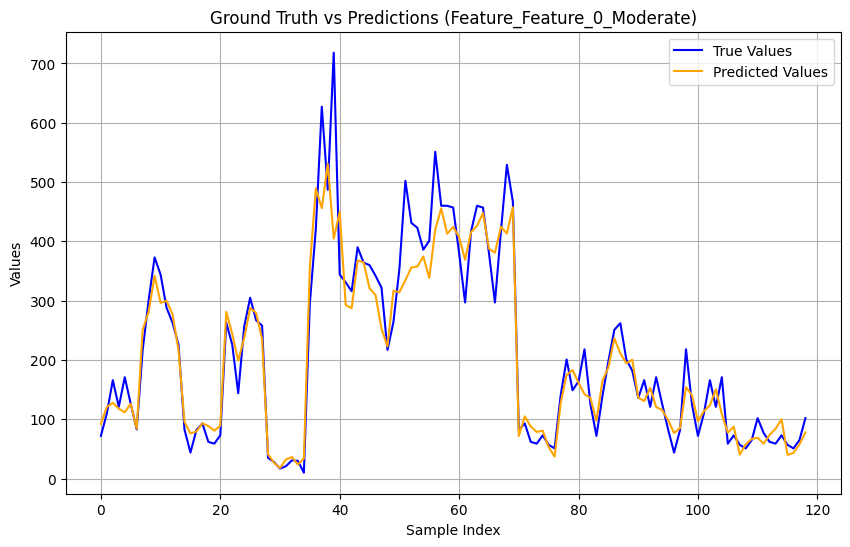

In [11]:
# Cell 6: Evaluation and Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

# Evaluate each trained model
evaluation_results = {}
for feature, model in trained_models.items():
    print(f"Evaluating model for {feature}...")
    test_predictions = model.predict(X_test.reshape(X_test.shape[0], -1))
    metrics = calculate_metrics(y_test.reshape(y_test.shape[0], -1), test_predictions)
    evaluation_results[feature] = metrics

# Print evaluation results
print("\nEvaluation Metrics for Each Feature:")
for feature, metrics in evaluation_results.items():
    print(f"{feature}: {metrics}")

# Save evaluation results
import pandas as pd
results_df = pd.DataFrame.from_dict(evaluation_results, orient="index")
results_df.to_csv(country_option+"evaluation_results.csv")
print("Evaluation metrics saved to 'Country evaluation_results.csv'")

if not trained_models:
    raise ValueError("No models were trained. Please check Cell 5 for issues in the adaptive training process.")

# Plot ground truth vs predictions for a sample feature
sample_feature = list(trained_models.keys())[0]  # Choose the first trained model as a sample
sample_model = trained_models[sample_feature]
sample_predictions = sample_model.predict(X_test.reshape(X_test.shape[0], -1))

plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label="True Values", color="blue")
plt.plot(sample_predictions.flatten(), label="Predicted Values", color="orange")
plt.title(f"Ground Truth vs Predictions ({sample_feature})")
plt.xlabel("Sample Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

### UPDATED Cell 7: Save Results

In [15]:
# Cell 7: Save Results

import pandas as pd
import joblib

# Save all models
model_save_path = f"{country_option}_trained_models.pkl"
joblib.dump(trained_models, model_save_path)
print(f"Trained models saved to: {model_save_path}")

# Save evaluation metrics
metrics_save_path = f"{country_option}_evaluation_metrics.csv"
evaluation_df = pd.DataFrame.from_dict(evaluation_results, orient="index")
evaluation_df.to_csv(metrics_save_path, index=False)
print(f"Evaluation metrics saved to: {metrics_save_path}")

# Save predictions for all features
predictions_save_path = f"{country_option}_predictions.xlsx"
with pd.ExcelWriter(predictions_save_path) as writer:
    for feature, model in trained_models.items():
        predictions = model.predict(X_test.reshape(X_test.shape[0], -1))
        predictions_df = pd.DataFrame({
            "True Values": y_test.flatten(),
            "Predicted Values": predictions.flatten()
        })
        predictions_df.to_excel(writer, sheet_name=feature[:30], index=False)

print(f"Predictions saved to: {predictions_save_path}")

# Save drift detection results
drift_save_path = f"{country_option}_drift_detection_results.csv"
drift_df = pd.DataFrame.from_dict(country_groups, orient="index").transpose()
drift_df.to_csv(drift_save_path, index=False)
print(f"Drift detection results saved to: {drift_save_path}")

# Save training times for features
training_times_path = f"{country_option}_training_times.csv"
training_times_df = pd.read_csv("adaptive_training_times.csv")  # Ensure compatibility with previous cells
training_times_df.to_csv(training_times_path, index=False)
print(f"Training times saved to: {training_times_path}")

# Save summary metrics
summary_metrics_path = f"{country_option}_summary_metrics.csv"
adaptive_summary_df = pd.read_csv("adaptive_summary_metrics.csv")  # Ensure compatibility with Cell 8
adaptive_summary_df.to_csv(summary_metrics_path, index=False)
print(f"Summary metrics saved to: {summary_metrics_path}")

Trained models saved to: Italy_trained_models.pkl
Evaluation metrics saved to: Italy_evaluation_metrics.csv
Predictions saved to: Italy_predictions.xlsx
Drift detection results saved to: Italy_drift_detection_results.csv
Training times saved to: Italy_training_times.csv
Summary metrics saved to: Italy_summary_metrics.csv


# ------------------------------------------------------------

# Model-2: Auto-ML for Covid-19 Forecasting (Baseline Model)

### Cell-1: Data & Dependencies Import

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autosklearn.regression import AutoSklearnRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Load the dataset
file_path = 'combined_late.csv'
data = pd.read_csv(file_path)

# Display the first few rows
data.head()


,date,country,cases,deaths,popData2020,continentExp,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,walking,driving
0,2021-03-01,Austria,456112,8414,8901064,Europe,-34.0,-1.0,12.0,-31.0,-26.0,7.0,80.34,89.13
1,2021-03-01,Belgium,777332,22282,11522440,Europe,-30.0,4.0,25.0,-31.0,-25.0,10.0,99.10,94.83
2,2021-03-01,Bulgaria,247038,10191,6951482,Europe,-26.0,3.0,-11.0,-5.0,-25.0,2.0,99.58,81.01
3,2021-03-01,Croatia,242973,5526,4058165,Europe,-17.0,9.0,38.0,-18.0,-13.0,1.0,106.52,79.95
4,2021-03-01,Czechia,1240051,20469,10693939,Europe,-56.0,-10.0,-19.0,-43.0,-33.0,15.0,46.11,63.62


### Cell-2: Convert date to datetime

In [81]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Scale features
data['scaled_deaths'] = data['deaths'] / (data['popData2020'] * 1e-6)

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Select features and target
features = [
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'walking',
    'driving'
]
X = data[features]
y = data['scaled_deaths']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


### UPDATED Cell-3: Approach-1: One Model for all Countries Approach


In [82]:
from autosklearn.regression import AutoSklearnRegressor
import pandas as pd
import numpy as np
import time
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import autosklearn

# Split data into training, validation, and test sets
print("Splitting data into train, validation, and test sets...")
train_data, temp_data = train_test_split(data, test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

# Define consistent preprocessing logic
def preprocess_data(data, target_column, window_size=None):
    """
    Preprocess the data consistently for training, validation, and testing.
    
    Args:
    - data: DataFrame containing the dataset.
    - target_column: Name of the target column.
    - window_size: If provided, create sliding windows for features.
    
    Returns:
    - X: Processed feature matrix.
    - y: Target values.
    """
    # Define the feature columns
    feature_columns = [
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline',
        'walking',
        'driving'
    ]
    X = data[feature_columns]
    y = data[target_column]

    # Create sliding windows if specified
    if window_size:
        X, y = create_sliding_windows(X, y, window_size)

    return X, y

def create_sliding_windows(X, y, window_size):
    """
    Create sliding windows for time-series data.
    """
    X_windows = []
    y_windows = []
    for i in range(len(X) - window_size + 1):
        X_windows.append(X.iloc[i:i+window_size].values.flatten())
        y_windows.append(y.iloc[i+window_size - 1])
    return np.array(X_windows), np.array(y_windows)

# Preprocess datasets with consistent logic
print("Preprocessing data...")
X_train, y_train = preprocess_data(train_data, target_column='deaths', window_size=None)
X_val, y_val = preprocess_data(val_data, target_column='deaths', window_size=None)
X_test, y_test = preprocess_data(test_data, target_column='deaths', window_size=None)

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Initialize AutoML model
automl_model = AutoSklearnRegressor(
    time_left_for_this_task=3600,  # Total time budget in seconds
    per_run_time_limit=300,       # Time limit for each model evaluation
    n_jobs=-1,                    # Use all available CPU cores
    metric=autosklearn.metrics.mean_squared_error  # Optimize for MSE
)

# Log training time
print("Training AutoML model for all countries...")
start_time = time.time()

# Train the model
automl_model.fit(X_train, y_train)

end_time = time.time()
training_time = (end_time - start_time) / 60  # Convert seconds to minutes
print(f"Training completed in {training_time:.2f} minutes.")

# Save the trained model
model_save_path = "baseline_model_all_countries.pkl"
joblib.dump(automl_model, model_save_path)
print(f"Model saved to: {model_save_path}")

# Save training time
training_time_df = pd.DataFrame([{"Training Time (mins)": training_time}])
training_time_df.to_csv("baseline_training_time_all_countries.csv", index=False)
print("Training time saved to 'baseline_training_time_all_countries.csv'.")

# Evaluate model performance on the validation set
print("Evaluating model on validation set...")
predictions_val = automl_model.predict(X_val)

# Calculate metrics
mse = mean_squared_error(y_val, predictions_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, predictions_val)

metrics_df.to_csv("baseline_metrics_all_countries.csv", index=False)
print("Validation metrics saved to 'baseline_metrics_all_countries.csv'.")

Splitting data into train, validation, and test sets...
Preprocessing data...
X_train shape: (2402, 8)
X_val shape: (515, 8)
X_test shape: (515, 8)
Scaling features...
Training AutoML model for all countries...


/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data/s4022297/env/uc/lib/python3.7/site-packages/numpy/core/_met

Training completed in 61.64 minutes.
Model saved to: baseline_model_all_countries.pkl
Training time saved to 'baseline_training_time_all_countries.csv'.
Evaluating model on validation set...
Validation metrics saved to 'baseline_metrics_all_countries.csv'.


### UPDATED Cell-4: Evaluate the model


Test Metrics - MSE: 4695.4084, RMSE: 68.5230, MAE: 43.8125
Test metrics saved to 'baseline_test_metrics_limited.csv'.


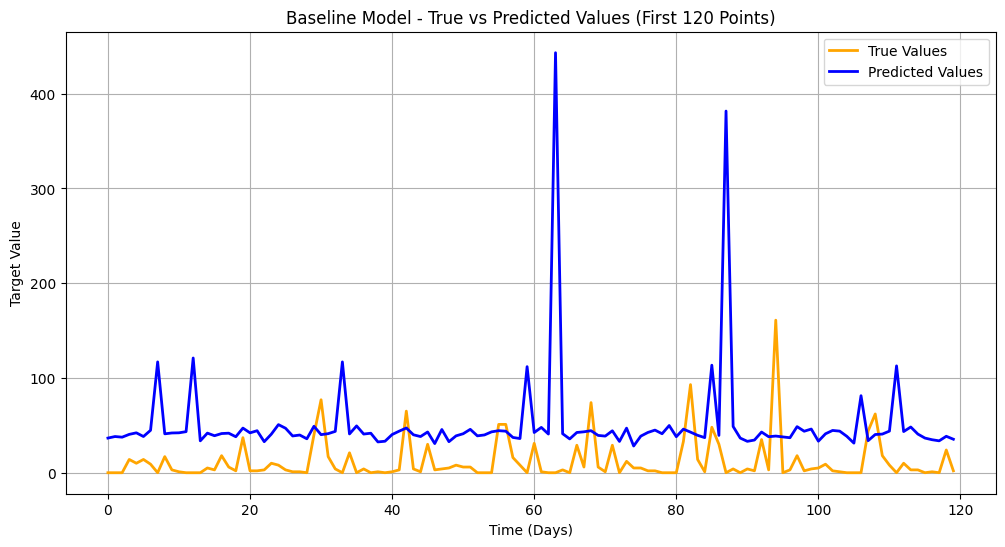

Limited predictions saved to 'baseline_predictions_limited.csv'.


In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Ensure y_test is flattened
if isinstance(y_test, pd.Series):
    y_test_flat = y_test.to_numpy().flatten()
elif isinstance(y_test, np.ndarray):
    y_test_flat = y_test.flatten()
else:
    raise TypeError("y_test must be a Pandas Series or NumPy array.")

# Ensure X_test is flattened
if isinstance(X_test, pd.DataFrame):
    X_test_flat = X_test.to_numpy().reshape(X_test.shape[0], -1)
elif isinstance(X_test, np.ndarray):
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
else:
    raise TypeError("X_test must be a Pandas DataFrame or NumPy array.")

# Make predictions
predictions_test = automl_model.predict(X_test_flat)

# Limit to first 120 data points
max_index = 120
y_test_limited = y_test_flat[:max_index]
predictions_limited = predictions_test[:max_index]

# Calculate metrics for limited range
mse = mean_squared_error(y_test_limited, predictions_limited)
rmse = mse**0.5
mae = mean_absolute_error(y_test_limited, predictions_limited)
print(f"Test Metrics - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# Save limited test metrics
metrics_df = pd.DataFrame([{
    "Metric": "MSE",
    "Value": mse,
}, {
    "Metric": "RMSE",
    "Value": rmse,
}, {
    "Metric": "MAE",
    "Value": mae,
}])
metrics_df.to_csv("baseline_test_metrics_limited.csv", index=False)
print("Test metrics saved to 'baseline_test_metrics_limited.csv'.")

# Plot True vs Predicted values for limited range
plt.figure(figsize=(12, 6))
plt.plot(
    range(len(y_test_limited)),
    y_test_limited,
    label="True Values",
    color="orange",
    linewidth=2,
)
plt.plot(
    range(len(predictions_limited)),
    predictions_limited,
    label="Predicted Values",
    color="blue",
    linewidth=2,
)
plt.title("Baseline Model - True vs Predicted Values (First 120 Points)")
plt.xlabel("Time (Days)")
plt.ylabel("Target Value")
plt.legend()
plt.grid()
plt.show()

# Save limited predictions
predictions_df = pd.DataFrame({
    "True Values": y_test_limited,
    "Predicted Values": predictions_limited,
})
predictions_df.to_csv("baseline_predictions_limited.csv", index=False)
print("Limited predictions saved to 'baseline_predictions_limited.csv'.")


# ------------------------------------------------------------

# Testing Performance Evaluation, Metrics & Visualization


### Cell-1: Data Import

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Load results from both models
adaptive_metrics_df = pd.read_csv("adaptive_model_metrics.csv")  # Metrics from adaptive drift-based model
baseline_metrics_df = pd.read_csv("baseline_metrics.csv")  # Metrics from baseline model

# Load training times
adaptive_training_times = pd.read_csv("adaptive_training_times.csv")  # Training times for adaptive model
baseline_training_times = pd.read_csv("baseline_training_times.csv")  # Training times for baseline model

# Load drifting features data
drifting_features_data = pd.read_csv("drifting_features.csv")  # Drifting feature data

# Cell 6 
### Model Accuracy Comparison

<Figure size 1000x600 with 0 Axes>

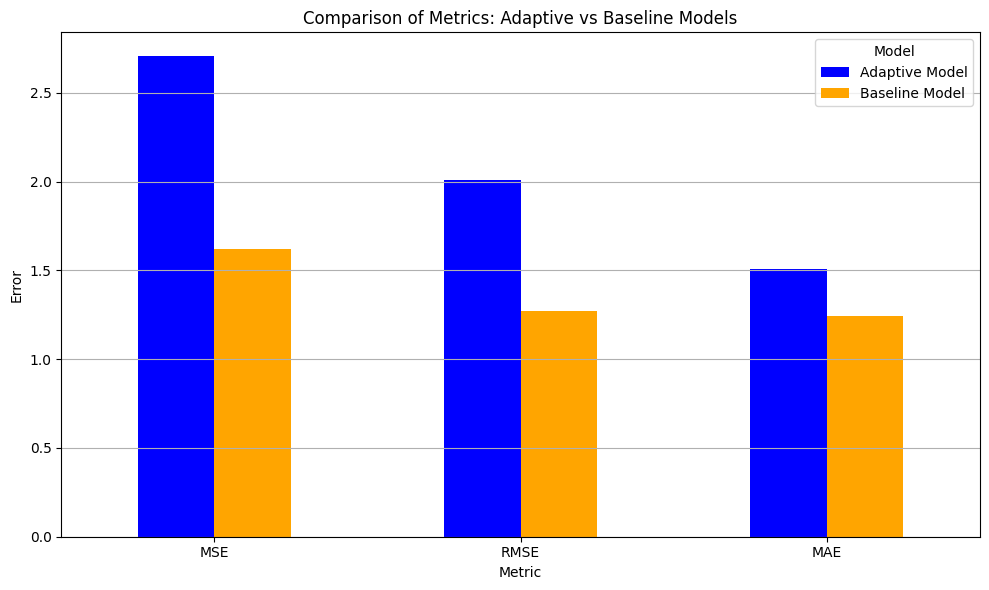

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
adaptive_summary_metrics = pd.read_csv('adaptive_summary_metrics.csv')
baseline_metrics = pd.read_csv('baseline_metrics.csv')

# Prepare data for plotting
# Extract metrics for adaptive and baseline models
adaptive_metrics = adaptive_summary_metrics.iloc[0, 1:4]  # MSE, RMSE, MAE
baseline_metrics_values = baseline_metrics.iloc[0, 1:4]   # MSE, RMSE, MAE

# Create a DataFrame for easier plotting
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'Adaptive Model': adaptive_metrics.values,
    'Baseline Model': baseline_metrics_values.values
})

# Plot the comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(x='Metric', kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title('Comparison of Metrics: Adaptive vs Baseline Models')
plt.ylabel('Error')
plt.xlabel('Metric')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Cell 7
### Training Time Comparison

<Figure size 1000x600 with 0 Axes>

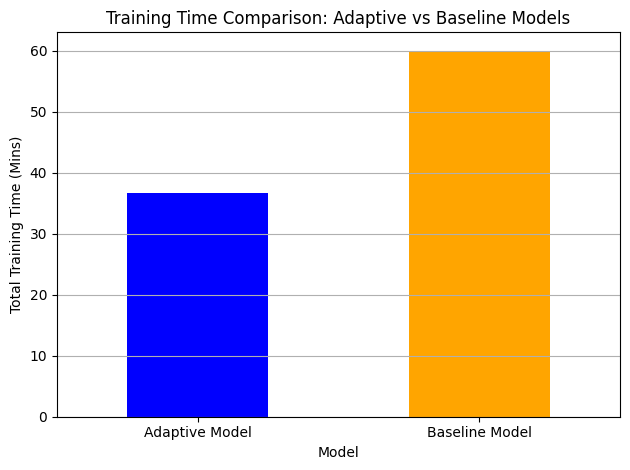

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
adaptive_training_time = pd.read_csv('Italy_training_times.csv')
baseline_training_time = pd.read_csv('baseline_training_time_all_countries.csv')

# Sum up training times for both models
adaptive_total_time = adaptive_training_time['Training Time (mins)'].sum()
baseline_total_time = baseline_training_time['Training Time (mins)'].sum()

# Create a DataFrame for comparison
training_time_comparison = pd.DataFrame({
    'Model': ['Adaptive Model', 'Baseline Model'],
    'Total Training Time (Mins)': [adaptive_total_time, baseline_total_time]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
training_time_comparison.plot(x='Model', y='Total Training Time (Mins)', kind='bar', color=['blue', 'orange'], legend=False)
plt.title('Training Time Comparison: Adaptive vs Baseline Models')
plt.ylabel('Total Training Time (Mins)')
plt.xlabel('Model')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
